In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
from cycler import cycler

rc("font", family="serif")
rc("text", usetex=True)
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['patch.linewidth'] = 2
matplotlib.rcParams['axes.prop_cycle'] =\
    cycler("color", ['k', 'c', 'm', 'y'])

import numpy as np
import sys
from astropy.table import Table
%cd /Users/bl/Dropbox/repos/Delight/

from delight.photoz_gp import PhotozGP

from eazyPy import *

/Users/bl/Dropbox/repos/Delight


In [2]:
fname = 'Buzzard_HighRes/Buzzard-highres_galaxies_shmatch.11104.fit'
bdata = Table.read(fname)
ZP = 12.5
rmag = bdata['OMAG'][:, 2].data
gmag = bdata['OMAG'][:, 1].data
rflux = 10**(-0.4*(rmag - ZP))
gflux = 10**(-0.4*(gmag - ZP))
redshift = bdata['Z'].data

In [3]:
bdata.colnames

['ID',
 'ECATID',
 'OMAG',
 'AMAG',
 'Z',
 'RA',
 'DEC',
 'PX',
 'PY',
 'PZ',
 'VX',
 'VY',
 'VZ',
 'EDGE',
 'HALOID',
 'M200',
 'NGALS',
 'R200',
 'RHALO',
 'CENTRAL',
 'MSTAR',
 'D8',
 'NNDIST',
 'NNPERCENT',
 'TE',
 'TSIZE']

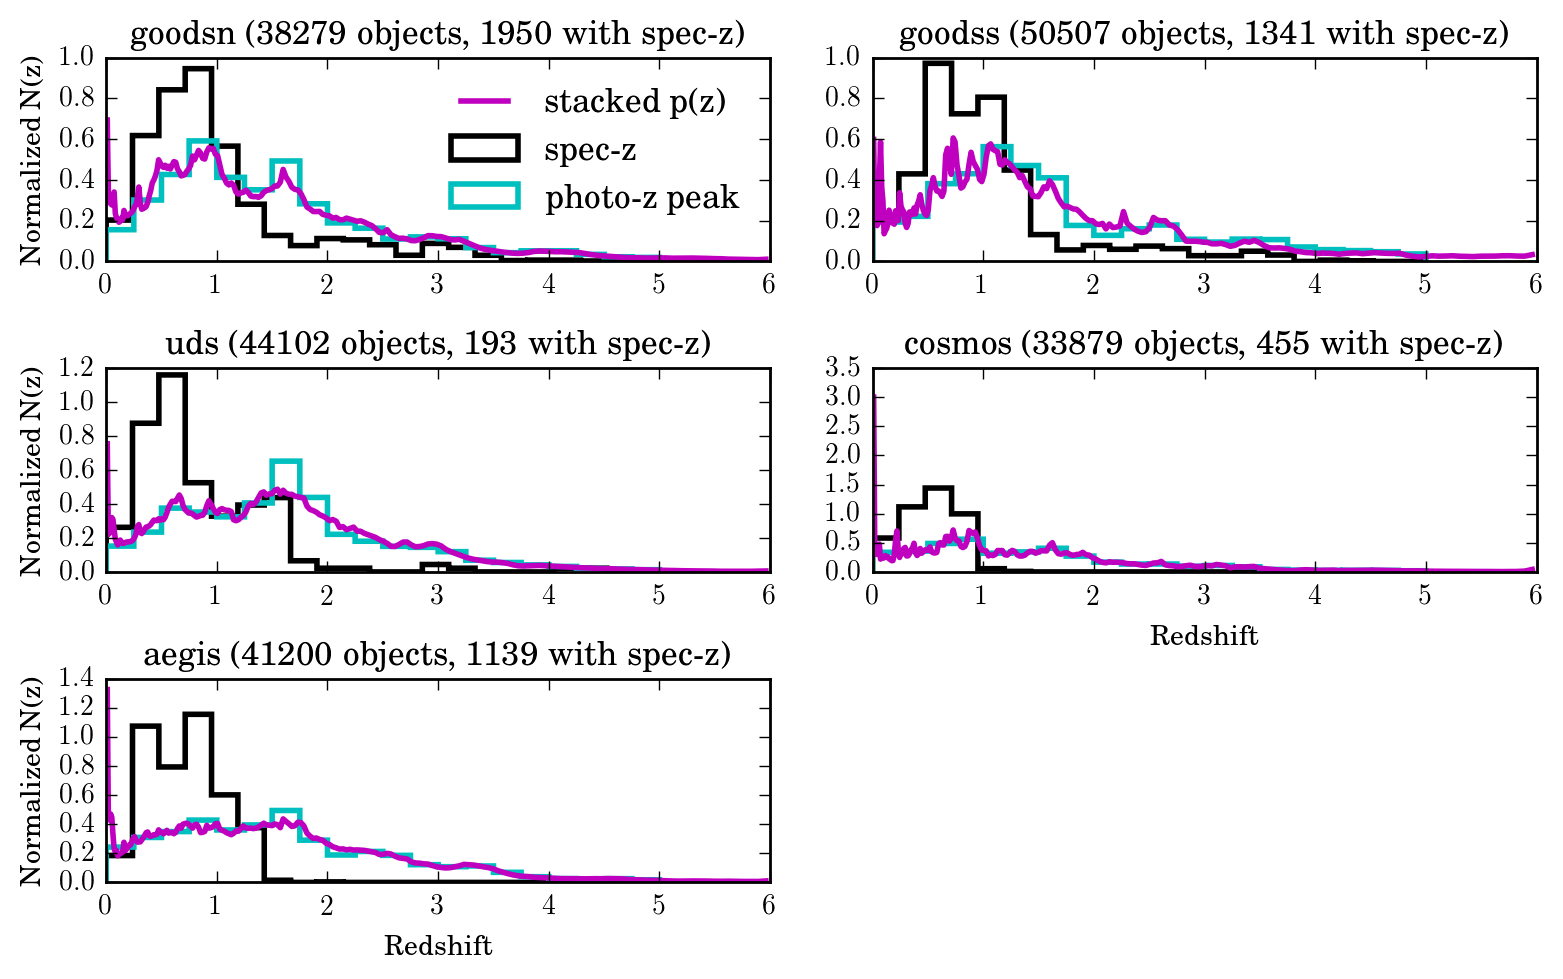

In [4]:
root = '/Users/bl/Dropbox/repos/Delight/hst3d/'
fieldnames = ['goodsn_3dhst.v4.1', 'goodss_3dhst.v4.1', 
              'uds_3dhst.v4.2', 'cosmos_3dhst.v4.1', 'aegis_3dhst.v4.1']
fig, axs = plt.subplots(3, 2, figsize=(8, 5))
axs = axs.ravel()
for i, fieldname in enumerate(fieldnames):
    easyroot = root+fieldname+'.cats/'+'Eazy'
    zout = np.genfromtxt(easyroot+'/'+fieldname+'.zout', names=True) 
    ind = zout['z_spec'] > 0
    axs[i].hist(zout['z_spec'][ind], 21, histtype='step', range=[0, 5], normed=True, label='spec-z')
    axs[i].hist(zout['z_peak'], 20, histtype='step', range=[0, 5], normed=True, label='photo-z peak')
    axs[i].set_title(fieldname[:-11]+" (%i"%zout['z_peak'].size+" objects, %i" % np.sum(ind) + " with spec-z)")
    zgrid, full_pz = getAllPz(MAIN_OUTPUT_FILE=fieldname, OUTPUT_DIRECTORY=easyroot)
    stackedpz = full_pz.sum(axis=1)
    stackedpz /= np.trapz(stackedpz, x=zgrid)
    axs[i].plot(zgrid, stackedpz, label='stacked p(z)')
for i in [0, 2, 4]:
    axs[i].set_ylabel('Normalized N(z)')
axs[-3].set_xlabel('Redshift')
axs[-2].set_xlabel('Redshift')
axs[0].legend(loc='upper right', frameon=False)
plt.delaxes(axs[-1])
fig.tight_layout()

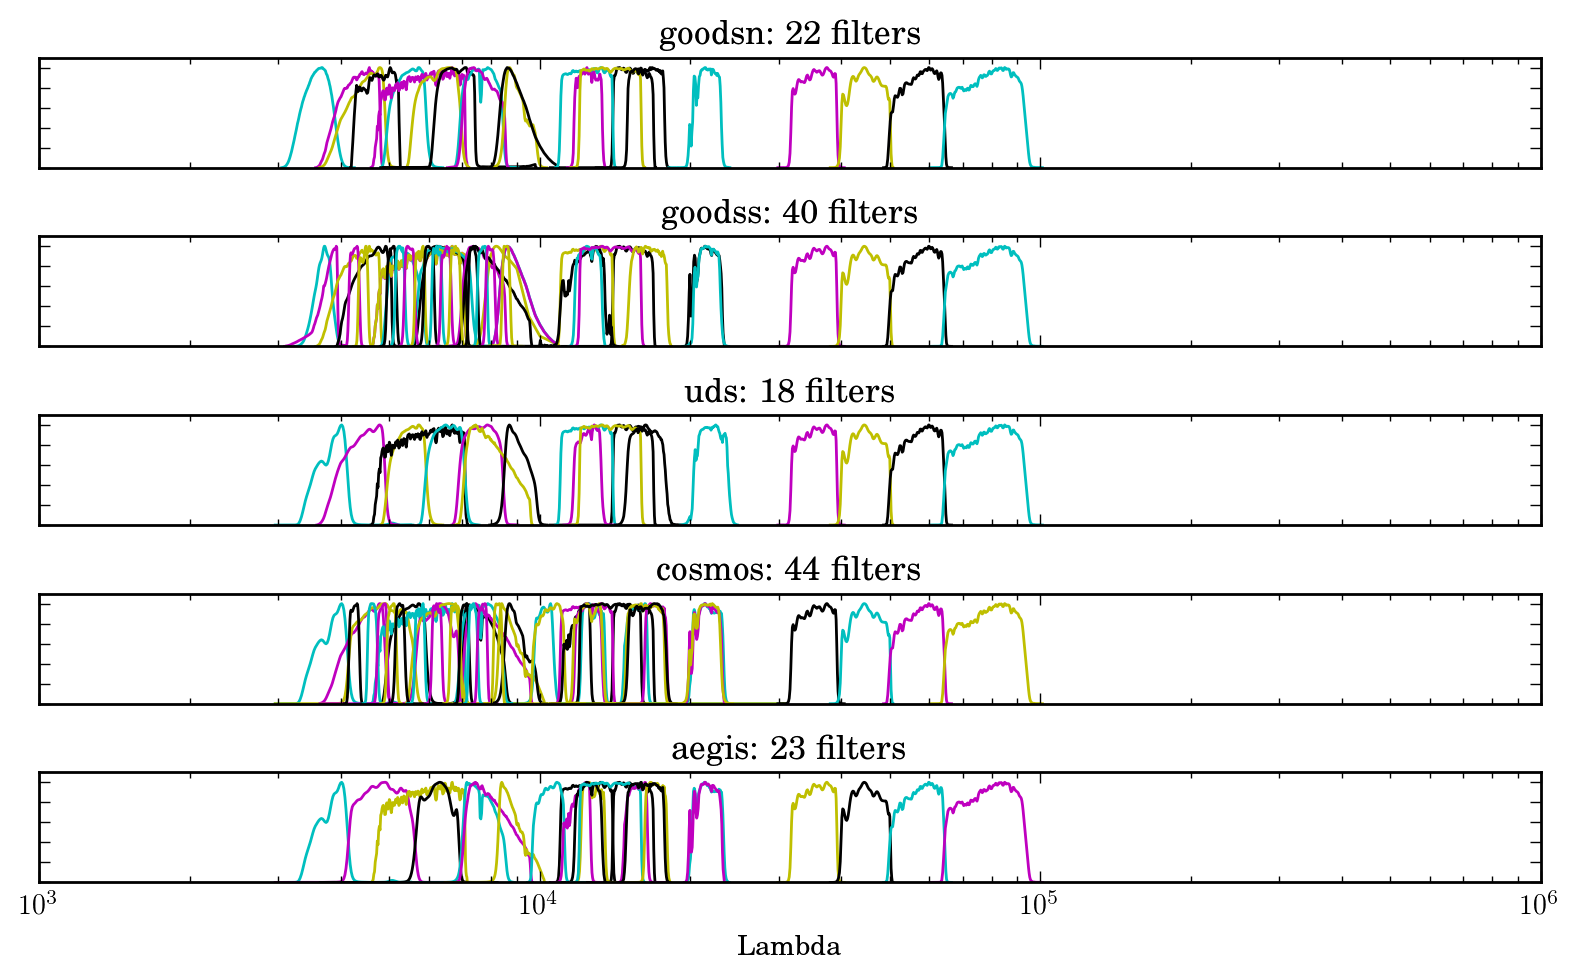

In [5]:
fig, axs = plt.subplots(5, 1, figsize=(8, 5), sharex=True)
axs = axs.ravel()
for i, fieldname in enumerate(fieldnames):
    easyroot = root+fieldname+'.cats/'+'Eazy'
    params = EazyParam(PARAM_FILE=easyroot+'/'+fieldname+'.param', READ_FILTERS=True)
    for j in range(params.NFILT):
        x, y = params.filters[j].wave, params.filters[j].throughput
        axs[i].plot(x, y, lw=1)
    axs[i].set_title(fieldname[:-11]+": %i"%params.NFILT+" filters")
    axs[i].set_xscale('log')
    axs[i].set_yticklabels([])
    axs[i].set_ylim([0, 1.1])
axs[-1].set_xlabel('Lambda')
fig.tight_layout()

In [6]:
numCoefs = 8

def dfunc(p, x, yd):
    y = 0*x
    n = p.size//2
    for i in range(n):
        y += np.abs(p[i]) * np.exp(-0.5*((mus[i]-x)/np.abs(p[n+i]))**2.0)
    return yd - y

from scipy.interpolate import interp1d
from scipy.optimize import leastsq

troot = '/Users/bl/Dropbox/repos/Delight/data/FILTERS'
bands = ['U_SDSS', 'G_SDSS', 'R_SDSS', 'I_SDSS', 'Z_SDSS']
numSDSSBands = len(bands)
SDSSbandCoefAmplitudes = np.zeros((numSDSSBands, numCoefs))
SDSSbandCoefPositions = np.zeros((numSDSSBands, numCoefs))
SDSSbandCoefWidths = np.zeros((numSDSSBands, numCoefs))
for j in range(numSDSSBands):
    fname_in = troot + '/' + bands[j] + '.res'
    data = np.genfromtxt(fname_in)
    coefs = np.zeros((numCoefs, 3))
    x, y = data[:, 0], data[:, 1]
    y /= y.max()
    y /= x
    ind = np.where(y > 0.01*np.max(y))[0]
    lambdaMin, lambdaMax = x[ind[0]], x[ind[-1]]
    sig0 = np.repeat((lambdaMax-lambdaMin)/numCoefs/4, numCoefs)
    mus = np.linspace(lambdaMin+sig0[0], lambdaMax-sig0[-1], num=numCoefs)
    amp0 = interp1d(x, y)(mus)
    p0 = np.concatenate((amp0, sig0))
    popt, pcov = leastsq(dfunc, p0, args=(x, y))
    SDSSbandCoefAmplitudes[j, :] = np.abs(popt[0:numCoefs])
    SDSSbandCoefPositions[j, :] = mus  # positions
    SDSSbandCoefWidths[j, :] = np.abs(popt[numCoefs:2*numCoefs]) 

In [7]:
z_ref = 0.5
ell_ref = 1e8

numZ = 2
redshiftGridGP = z_ref + np.linspace(-0.00, +0.01, numZ)
redshiftGrid = 1*redshiftGridGP
lines_pos, lines_width = np.array([6500.]), np.array([20.0])
V_C, V_L, alpha_C, alpha_L = 0.01, 0.01, 1e3, 1e2

from delight.utils import approx_DL
DL = approx_DL()

In [8]:
from delight.photoz_kernels import Photoz_linear_sed_basis

In [110]:
bands = ['U_SDSS', 'G_SDSS', 'R_SDSS', 'I_SDSS', 'Z_SDSS']
for i, fieldname in enumerate(fieldnames[:1]):
    easyroot = root+fieldname+'.cats/'+'Eazy'
    params = EazyParam(PARAM_FILE=easyroot+'/'+fieldname+'.param', READ_FILTERS=True)
    numBands = params.NFILT
  
    bandCoefAmplitudes = np.zeros((numBands+numSDSSBands, numCoefs))
    bandCoefPositions = np.zeros((numBands+numSDSSBands, numCoefs))
    bandCoefWidths = np.zeros((numBands+numSDSSBands, numCoefs))
    for j in range(numBands):
        x, y = params.filters[j].wave, params.filters[j].throughput
        y /= x
        ind = np.where(y > 0.01*np.max(y))[0]
        lambdaMin, lambdaMax = x[ind[0]], x[ind[-1]]
        sig0 = np.repeat((lambdaMax-lambdaMin)/numCoefs/4, numCoefs)
        mus = np.linspace(lambdaMin+sig0[0], lambdaMax-sig0[-1], num=numCoefs)
        amp0 = interp1d(x, y)(mus)
        p0 = np.concatenate((amp0, sig0))
        popt, pcov = leastsq(dfunc, p0, args=(x, y))
        bandCoefAmplitudes[j, :] = np.abs(popt[0:numCoefs])
        bandCoefPositions[j, :] = mus  # positions
        bandCoefWidths[j, :] = np.abs(popt[numCoefs:2*numCoefs]) 
        
    bandCoefAmplitudes[-5:, :] = SDSSbandCoefAmplitudes
    bandCoefPositions[-5:, :] = SDSSbandCoefPositions
    bandCoefWidths[-5:, :] = SDSSbandCoefWidths
            
    norms = np.sqrt(2*np.pi) * np.sum(bandCoefAmplitudes * bandCoefWidths, axis=1)
    f_mod_interp = np.zeros((1, numBands+numSDSSBands), dtype=object)
    gp = PhotozGP(
            f_mod_interp, bandCoefAmplitudes, bandCoefPositions, bandCoefWidths,
            lines_pos, lines_width, V_C, V_L, alpha_C, alpha_L,
            redshiftGridGP, use_interpolators=False)
    
    zout = np.genfromtxt(easyroot+'/'+fieldname+'.zout', names=True) 
    numObj = zout.shape[0]
    predFluxesSDSS2 = np.zeros((numObj, numSDSSBands))
    predFluxes = np.zeros((numZ, numObj, numBands+numSDSSBands))
    predFluxesVar = np.zeros((numZ, numObj, numBands+numSDSSBands))
    numBandsUsed = np.zeros((numObj, ), dtype=int)
    fullmask = np.repeat(False, numObj)
    for idx in range(numObj):
        lambdaz, temp_sed, lci, obs_sed, fobs, efobs =\
                getEazySED(idx, MAIN_OUTPUT_FILE=fieldname, OUTPUT_DIRECTORY=easyroot,
                           scale_flambda=1.e-17, verbose=False, individual_templates=False)
            
        mask = np.isfinite(fobs)
        mask &= np.isfinite(efobs)
        mask &= fobs > 0.0
        mask &= efobs > 0.0
        bandsUsed = np.where(mask)[0]
        numBandsUsed[idx] = mask.sum()

        if numBandsUsed[idx] > 10:
            
            f_mod_interp = np.zeros((1, numBands+numSDSSBands), dtype=object)
            for j in range(numBands):
                x, y = params.filters[j].wave, params.filters[j].throughput
                y /= x
                filt = np.interp(lambdaz, x, y)
                norm = np.trapz(y, x=x) * ell_ref
                fluxes = np.repeat(np.trapz(filt * temp_sed, x=lambdaz) / norm, redshiftGridGP.size)
                f_mod_interp[0, j] =\
                    interp1d(redshiftGridGP, fluxes,
                             kind='linear', bounds_error=False, fill_value='extrapolate')   
            for j in range(numSDSSBands):
                fname_in = troot + '/' + bands[j] + '.res'
                data = np.genfromtxt(fname_in)
                data[:, 1] /= data[:, 0]
                filt = np.interp(lambdaz, data[:, 0], data[:, 1])
                norm = np.trapz(data[:, 1], x=data[:, 0]) * ell_ref
                fluxes = np.repeat(np.trapz(filt * temp_sed, x=lambdaz) / norm, redshiftGridGP.size)
                f_mod_interp[0, numBands+j] =\
                    interp1d(redshiftGridGP, fluxes,
                             kind='linear', bounds_error=False, fill_value='extrapolate')

            gp.mean_fct = Photoz_linear_sed_basis(f_mod_interp)

            fullmask[idx] = True
            Y = fobs[mask, None]
            Yvar = efobs[mask, None]**2.
            X = np.zeros((numBandsUsed[idx], 3))
            X[:, 0] = bandsUsed
            X[:, 1] = z_ref
            X[:, 2] = ell_ref
            
            gp.setData(X, Y, Yvar, bestType=0)

            gp.optimizeHyperparamaters(x0=[1.0, 1e2], verbose=False)
            
            predFluxes[:, idx, :], predFluxesVar[:, idx, :] =\
                gp.predictAndInterpolate(redshiftGrid, ell=ell_ref)
            #x_pred = np.zeros((numBands+numSDSSBands, 3))
            #x_pred[:, 0] = np.arange(numBands+numSDSSBands)
            #x_pred[:, 1] = z_ref
            #x_pred[:, 2] = ell_ref
            #f1, f2 = gp.predict(x_pred, diag=True)
            #predFluxes[0, idx, :], predFluxesVar[0, idx, :] = f1.ravel(), f2.ravel()
            
            if False:
                for j in range(numBandsUsed[idx]):
                    fluxes1 = gp.mean_fct.f(X)[j, 0]
                    fluxes2 = predFluxes[0, idx, bandsUsed[j]]
                    fluxes3 = fobs[bandsUsed[j]]
                    print(j, fluxes1, fluxes2, fluxes3)
            
            for j in range(numSDSSBands):
                fname_in = troot + '/' + bands[j] + '.res'
                data = np.genfromtxt(fname_in)
                data[:, 1] /= data[:, 0]
                filt = np.interp(lambdaz, data[:, 0], data[:, 1])
                
                norm = np.trapz(data[:, 1], x=data[:, 0])
                predFluxesSDSS2[idx, j] = np.trapz(filt * temp_sed, x=lambdaz) / norm

            if False:
                inds = np.array([7, 9, 11])  # r i z
                print('d', fobs[inds], efobs[inds])
                inds = np.array([2, 3, 4])   # r i z
                print('p', predFluxes[numZ//2, idx, inds - 5], predFluxesSDSS2[idx, inds])
            if False:
                y = fobs[mask]/predFluxes[numZ//2, idx, mask]
                print('mean/trueMean:', np.mean(y), np.max(y))
                y = efobs[mask]/predFluxesVar[numZ//2, idx, mask]**0.5
                print('var/trueVar:', np.mean(y), np.max(y))
                y = predFluxesVar[numZ//2, idx, -5:]**0.5/predFluxes[numZ//2, idx, -5:]
                print('var/mean:', np.mean(y), np.max(y))
                print(" --- ")
            #stop

/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in double_scalars


KeyboardInterrupt: 

In [122]:
np.sum(numBandsUsed[fullmask] > 0)

3023

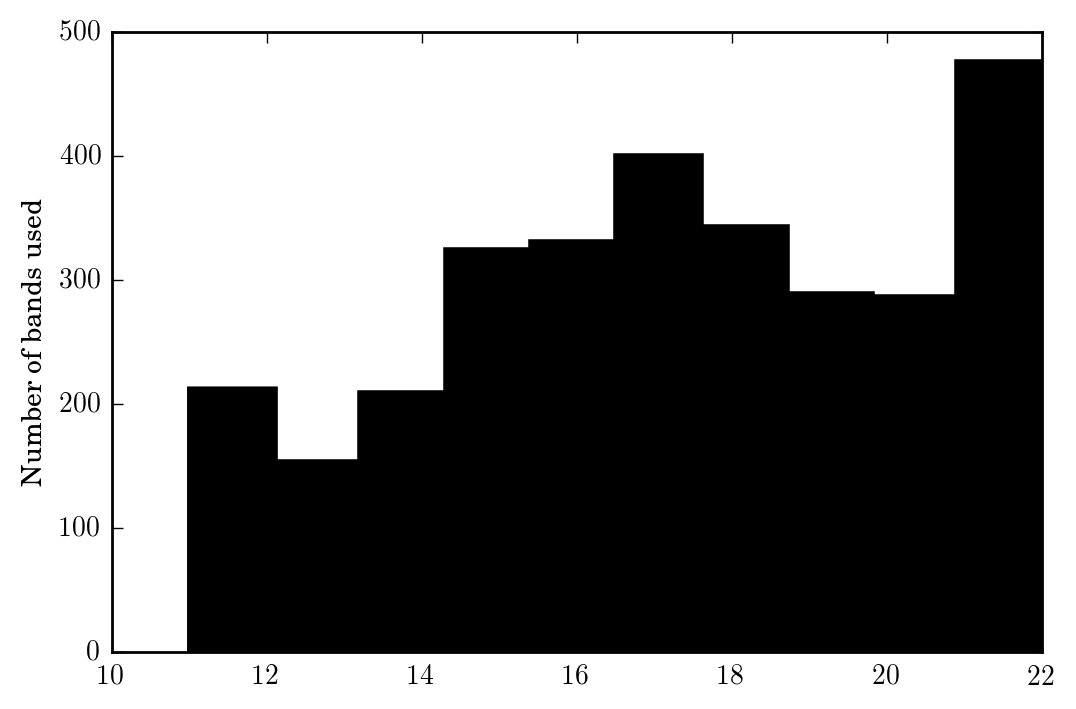

In [111]:
plt.hist(numBandsUsed[fullmask])#, range=[1, 30])
plt.ylabel('Number of bands used')

/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in true_divide


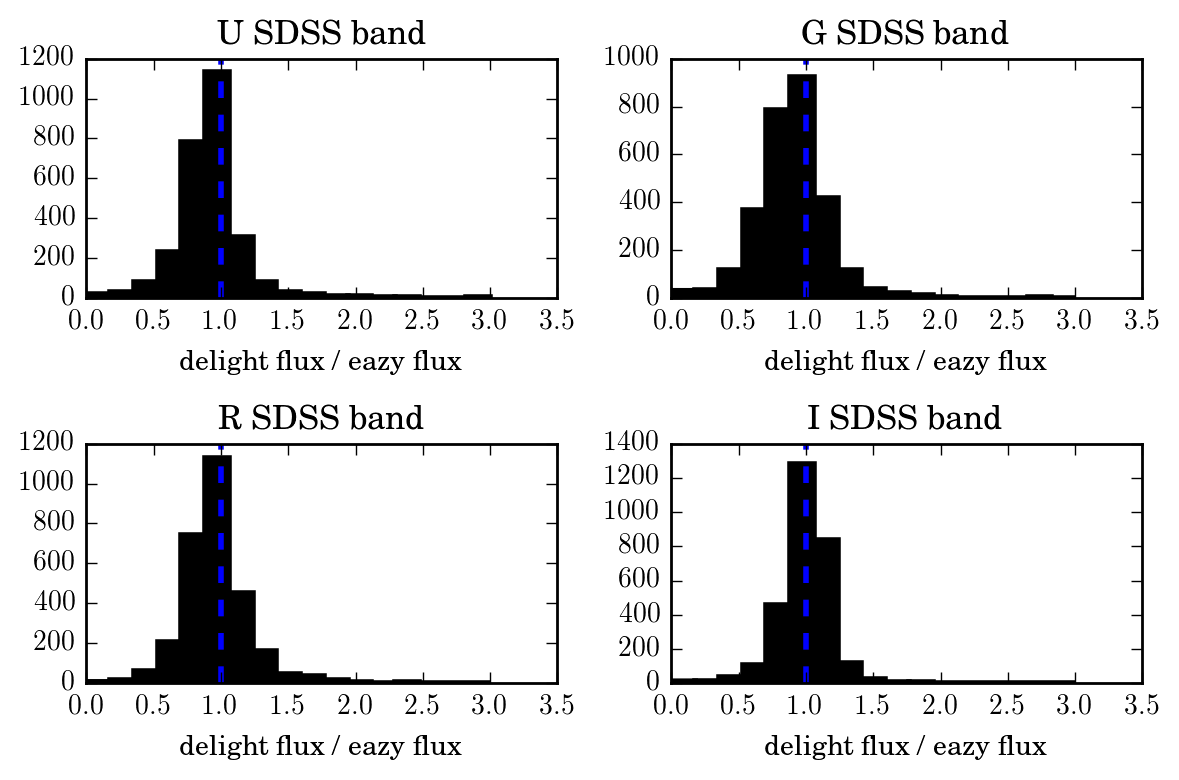

In [112]:
inds = np.array([1, 2, 3, 4])   # r i z
vec1 = predFluxes[numZ//2, :, :][fullmask, :][:, inds - 5]
vec2 = predFluxesSDSS2[:, inds][fullmask, :]
rat = vec1 / vec2
fig, axs = plt.subplots(2, 2, figsize=(6, 4))
axs = axs.ravel()
axs[0].hist(rat[:, 0], 17, range=[0, 3])
axs[1].hist(rat[:, 1], 17, range=[0, 3])
axs[2].hist(rat[:, 2], 17, range=[0, 3])
axs[3].hist(rat[:, 3], 17, range=[0, 3])
for i in range(4):
    axs[i].axvline(1, ls='dashed')
    axs[i].set_title(bands[i][0]+' SDSS band')
    axs[i].set_xlabel('delight flux / eazy flux')
fig.tight_layout()

In [113]:
# f_obs and f_obs_var are nz * nt * nf. f_mod is nf
def scalefree_flux_likelihood(f_obs, f_obs_var, f_mod, returnChi2=False):
    nz, nt, nf = f_obs.shape
    var = f_obs_var  # nz * nt * nf
    invvar = np.where(f_obs/var < 1e-6, 0.0, var**-1.0)  # nz * nt * nf
    FOT = np.sum(f_mod * f_obs * invvar, axis=2)  # nz * nt
    FTT = np.dot(invvar, f_mod**2)  # nz * nt
    FOO = np.sum(f_obs**2 * invvar, axis=2)  # nz * nt
    ellML = FOT / FTT
    chi2 = FOO - FOT**2.0 / FTT  # nz * nt
    like = np.exp(-0.5*chi2) / np.sqrt(FTT)  # nz * nt
    return like, ellML

zz, full_pz = getAllPz(MAIN_OUTPUT_FILE=fieldname, OUTPUT_DIRECTORY=easyroot)

In [123]:
ind = np.array([1, 2]) # G and R bands only
inds = numBandsUsed > 4
inds &= fullmask
inds &= np.all(np.isfinite(predFluxes[:, :, ind]), axis=(0, 2))
inds &= np.all(np.isfinite(predFluxesVar[:, :, ind]), axis=(0, 2))
sel = np.where(inds)[0]
print('Valid 3DHST objects: ', sel.size)

ind_sim = redshift < 1.0
ind_sim &= redshift > 0.1
ind_sim &= rmag < 22.5
ind_sim.sum()
sel_sim = np.where(ind_sim)[0]
np.random.shuffle(sel_sim)
sel_sim = sel_sim[:50000]

new_idx = np.zeros((sel_sim.size, ), dtype=int)
new_z = np.zeros((sel_sim.size, ))
new_fluxes = np.zeros((sel_sim.size, 5))
for ii, i in enumerate(sel_sim):
    z_sim = redshift[i]
    simFluxes = np.array([gflux[i], rflux[i]])
    
    themean = predFluxes[:, sel, :][:, :, ind-5]
    #for iz in range(themean.shape[0]):
    #    themean[iz, :, :] = predFluxesSDSS2[sel, :][:, ind]
    #thevar = (themean / 10.0)**2.0
    thevar = predFluxesVar[:, sel, :][:, :, ind]

    like, ellML = scalefree_flux_likelihood(themean, thevar, simFluxes)

    z_off = redshiftGrid - z_ref
    pzi = np.zeros((numZ, sel.size))
    for k, j in enumerate(sel):
        pzi[:, k] = np.interp(z_sim + z_off, zz, full_pz[:, j])
    
    like *= pzi # nz * nobj
    like[~np.isfinite(like)] = 0
    like /= np.sum(like, axis=1)[:, None]
    
    idz = 0
    ran = np.random.multinomial(1, like[idz, :], size=1)[0]
    idx0 = np.where(ran > 0)[0]
    idx1 = np.array([np.argmax(like[idz, :])])
    idx = idx0

    #print('--')
    #print(z_sim, idx0, idx1, simFluxes, like[idz, :].max())
    #print(simFluxes * ellML[idz, idx])
    #print(predFluxes[:, sel[idx], :][:, :, ind][idz, :, :])
    
    new_fluxes_mean = predFluxes[idz, sel[idx], -5:] / ellML[idz, idx]
    new_fluxes_err = predFluxesVar[idz, sel[idx], -5:]**0.5 / ellML[idz, idx]
    new_idx[ii] = sel[idx]
    new_z[ii] = zout['z_peak'][sel[idx]]
    new_fluxes[ii, :] = new_fluxes_mean# + new_fluxes_err*np.random.randn(5)
    
    #stop

Valid 3DHST objects:  3023


/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in true_divide
/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide


In [136]:
idx0, idx1

(array([663]), array([134]))

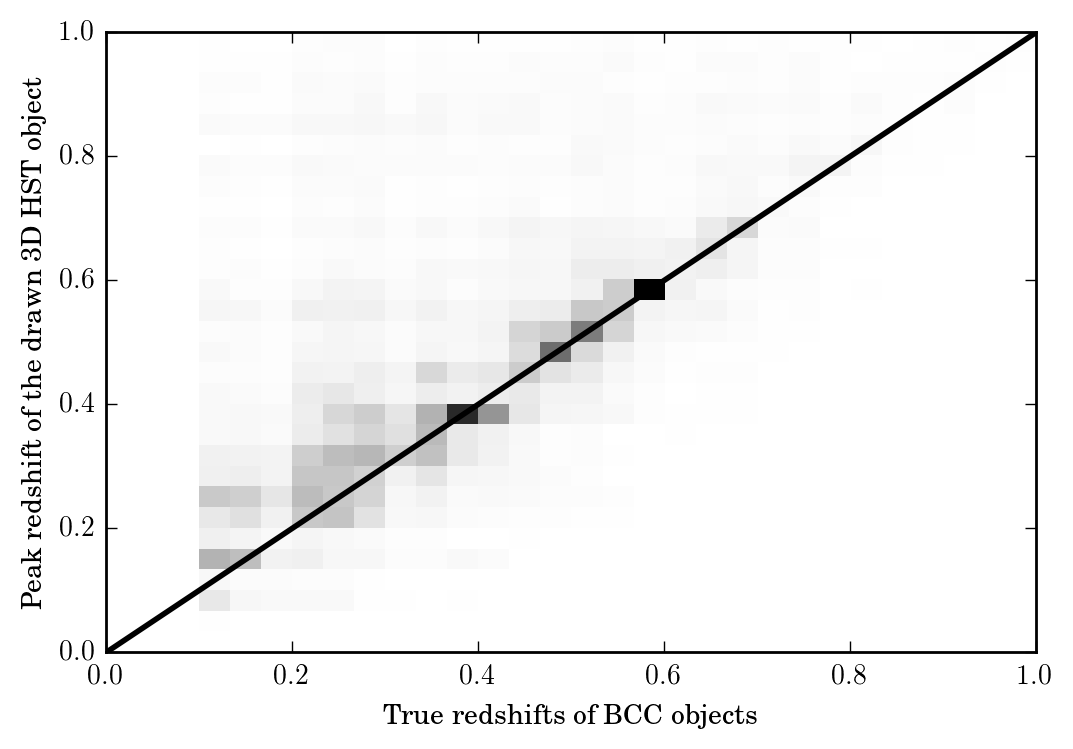

In [133]:
fig, ax = plt.subplots(1, 1)
ax.hist2d(redshift[sel_sim], new_z, 30, cmap="Greys", range=[[0, 1], [0, 1]])
ax.plot([0, 1], [0, 1])
ax.set_xlabel('True redshifts of BCC objects')
ax.set_ylabel('Peak redshift of the drawn 3D HST object')

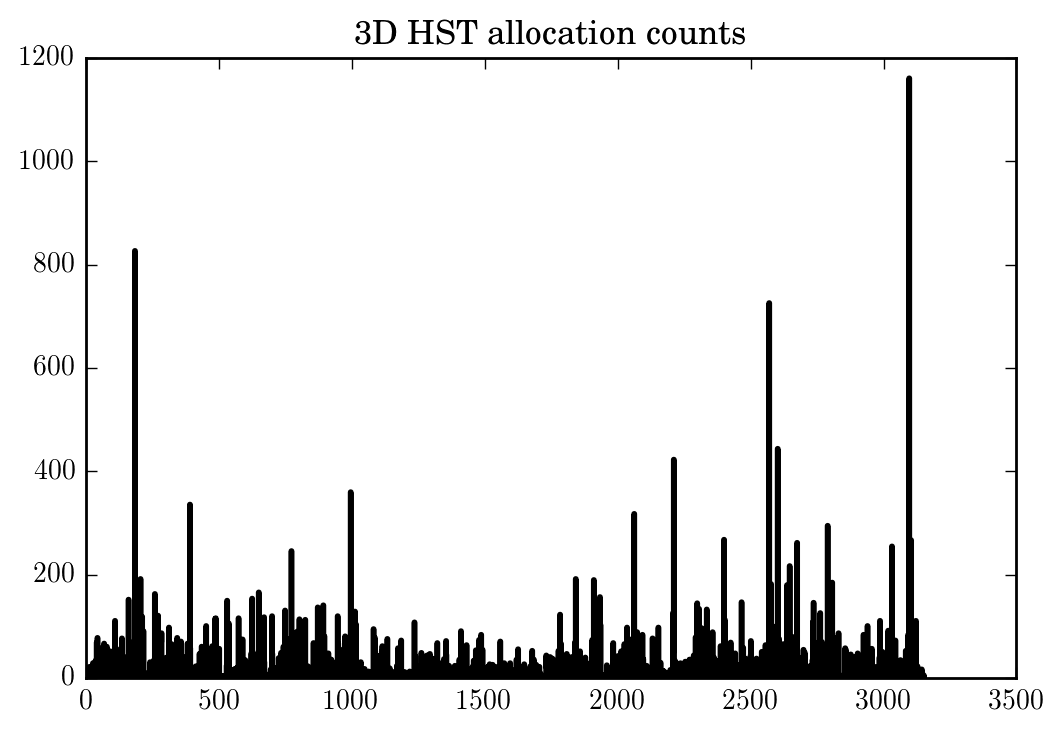

In [125]:
fig, ax = plt.subplots(1, 1)
ax.plot(np.bincount(new_idx), ls='steps')
ax.set_title('3D HST allocation counts')

In [126]:
new_rmag = -2.5*np.log10(new_fluxes[:, 2]) + ZP
new_gmag = -2.5*np.log10(new_fluxes[:, 1]) + ZP
g_r_col = gmag - rmag
new_g_r_col = new_gmag - new_rmag
ind2 = np.arange(sel_sim.size) > -1
ind2 &= np.isfinite(new_rmag)
ind2 &= np.isfinite(new_gmag)

/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


In [127]:
all_sdss_mags = bdata['OMAG'][sel_sim, :].data
all_new_sdss_mags = -2.5*np.log10(new_fluxes[:, :]) + ZP

/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


/Users/bl/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])
/Users/bl/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/bl/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


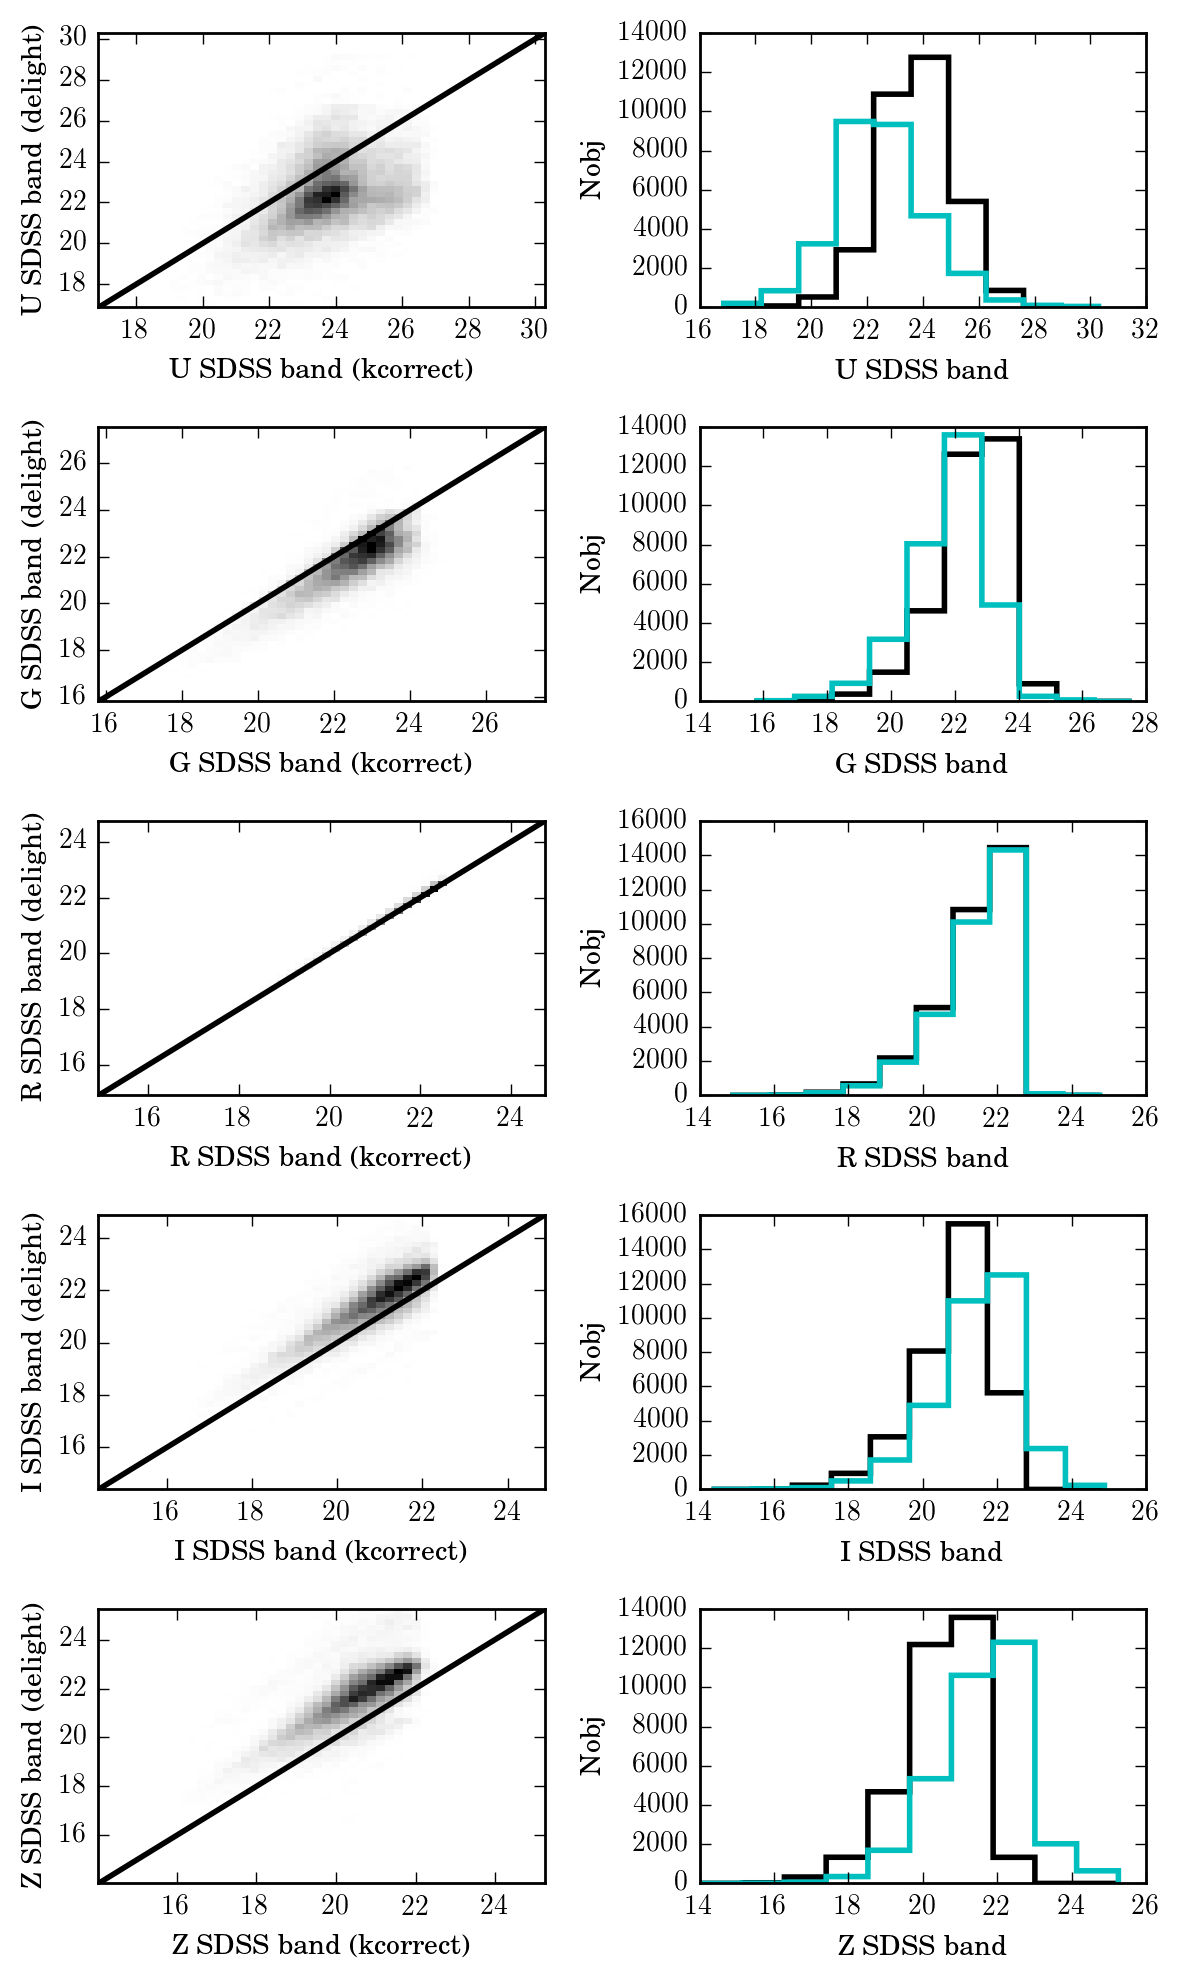

In [141]:
nbins = 50
fig, axs = plt.subplots(5, 2, figsize=(6, 10))
bands = ['U', 'G', 'R', 'I', 'Z']
for i in range(5):
    ind = np.isfinite(all_new_sdss_mags[:, i])
    xmin, xmax = 0.95*np.min(all_sdss_mags[:, i]), 1.1*np.max(all_sdss_mags[:, i])
    axs[i, 0].hist2d(all_sdss_mags[:, i], all_new_sdss_mags[:, i],
                  nbins, cmap='gray_r', range=[[xmin, xmax], [xmin, xmax]])
    axs[i, 0].plot([xmin, xmax], [xmin, xmax])
    axs[i, 0].set_xlim([xmin, xmax])
    axs[i, 0].set_ylim([xmin, xmax])
    axs[i, 0].set_ylabel(bands[i]+' SDSS band (delight)')
    axs[i, 0].set_xlabel(bands[i]+' SDSS band (kcorrect)')
    axs[i, 1].hist(all_sdss_mags[:, i], range=[xmin, xmax], histtype="step")
    axs[i, 1].hist(all_new_sdss_mags[:, i], range=[xmin, xmax], histtype="step")
    axs[i, 1].set_ylabel('Nobj')
    axs[i, 1].set_xlabel(bands[i]+' SDSS band')

fig.tight_layout()

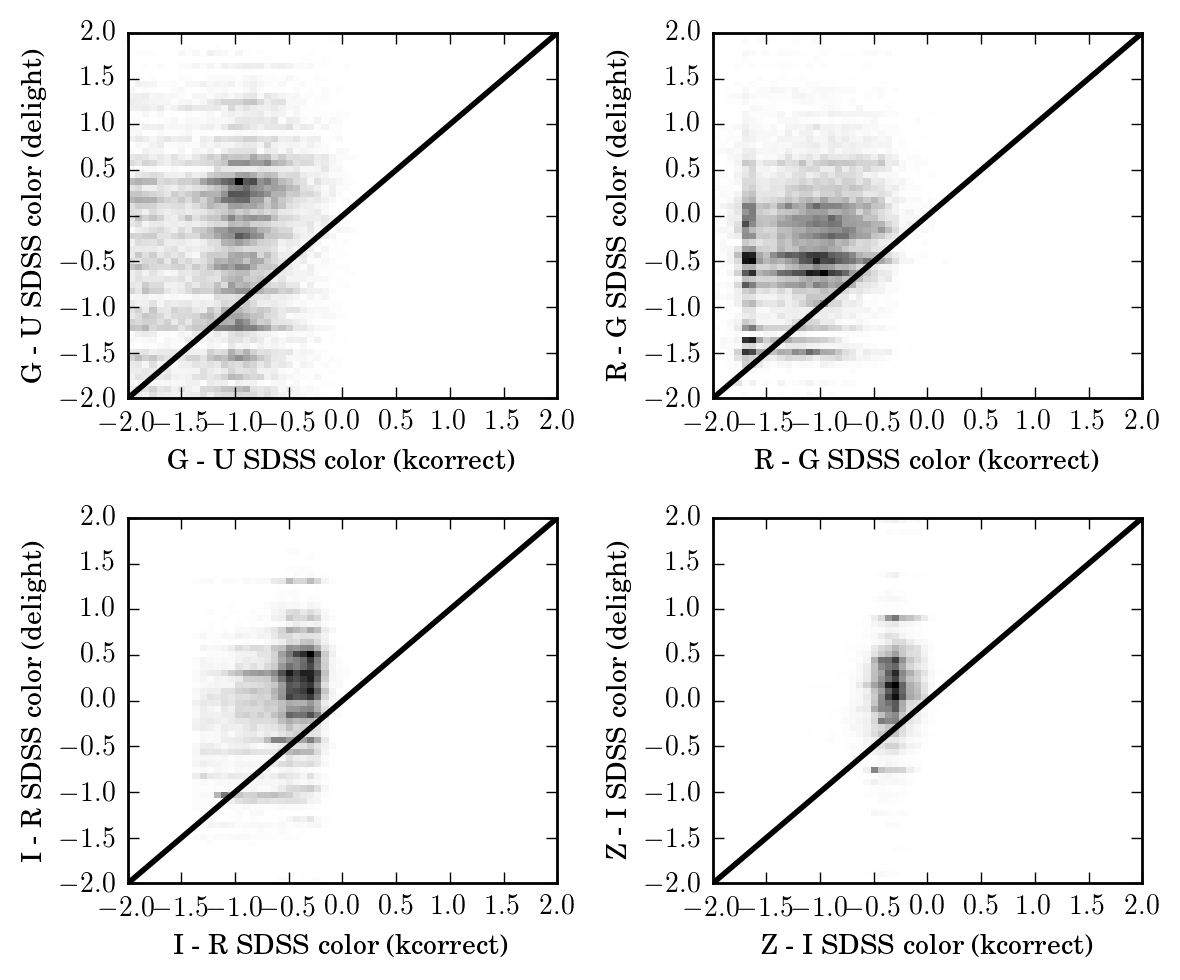

In [129]:
nbins = 50
fig, axs = plt.subplots(2, 2, figsize=(6, 5))
axs = axs.ravel()
bands = ['U', 'G', 'R', 'I', 'Z']
for i in range(4):
    ind = np.isfinite(all_new_sdss_mags[:, i+1])
    ind &= np.isfinite(all_new_sdss_mags[:, i])
    thecol = all_sdss_mags[ind, i+1] - all_sdss_mags[ind, i]
    thenewcol = all_new_sdss_mags[ind, i+1] - all_new_sdss_mags[ind, i]
    xmin1, xmax1 = np.min(thecol), np.max(thecol)
    xmin2, xmax2 = np.min(thenewcol), np.max(thenewcol)
    xmin, xmax = -2, 2#np.min([xmin1, xmin2]), np.max([xmax1, xmax2])
    axs[i].hist2d(thecol, thenewcol, nbins, cmap='gray_r', range=[[xmin, xmax], [xmin, xmax]])
    axs[i].plot([xmin, xmax], [xmin, xmax])
    axs[i].set_xlim([xmin, xmax])
    axs[i].set_ylim([xmin, xmax])
    axs[i].set_ylabel(bands[i+1]+' - '+bands[i]+' SDSS color (delight)')
    axs[i].set_xlabel(bands[i+1]+' - '+bands[i]+' SDSS color (kcorrect)')
fig.tight_layout()

/Users/bl/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


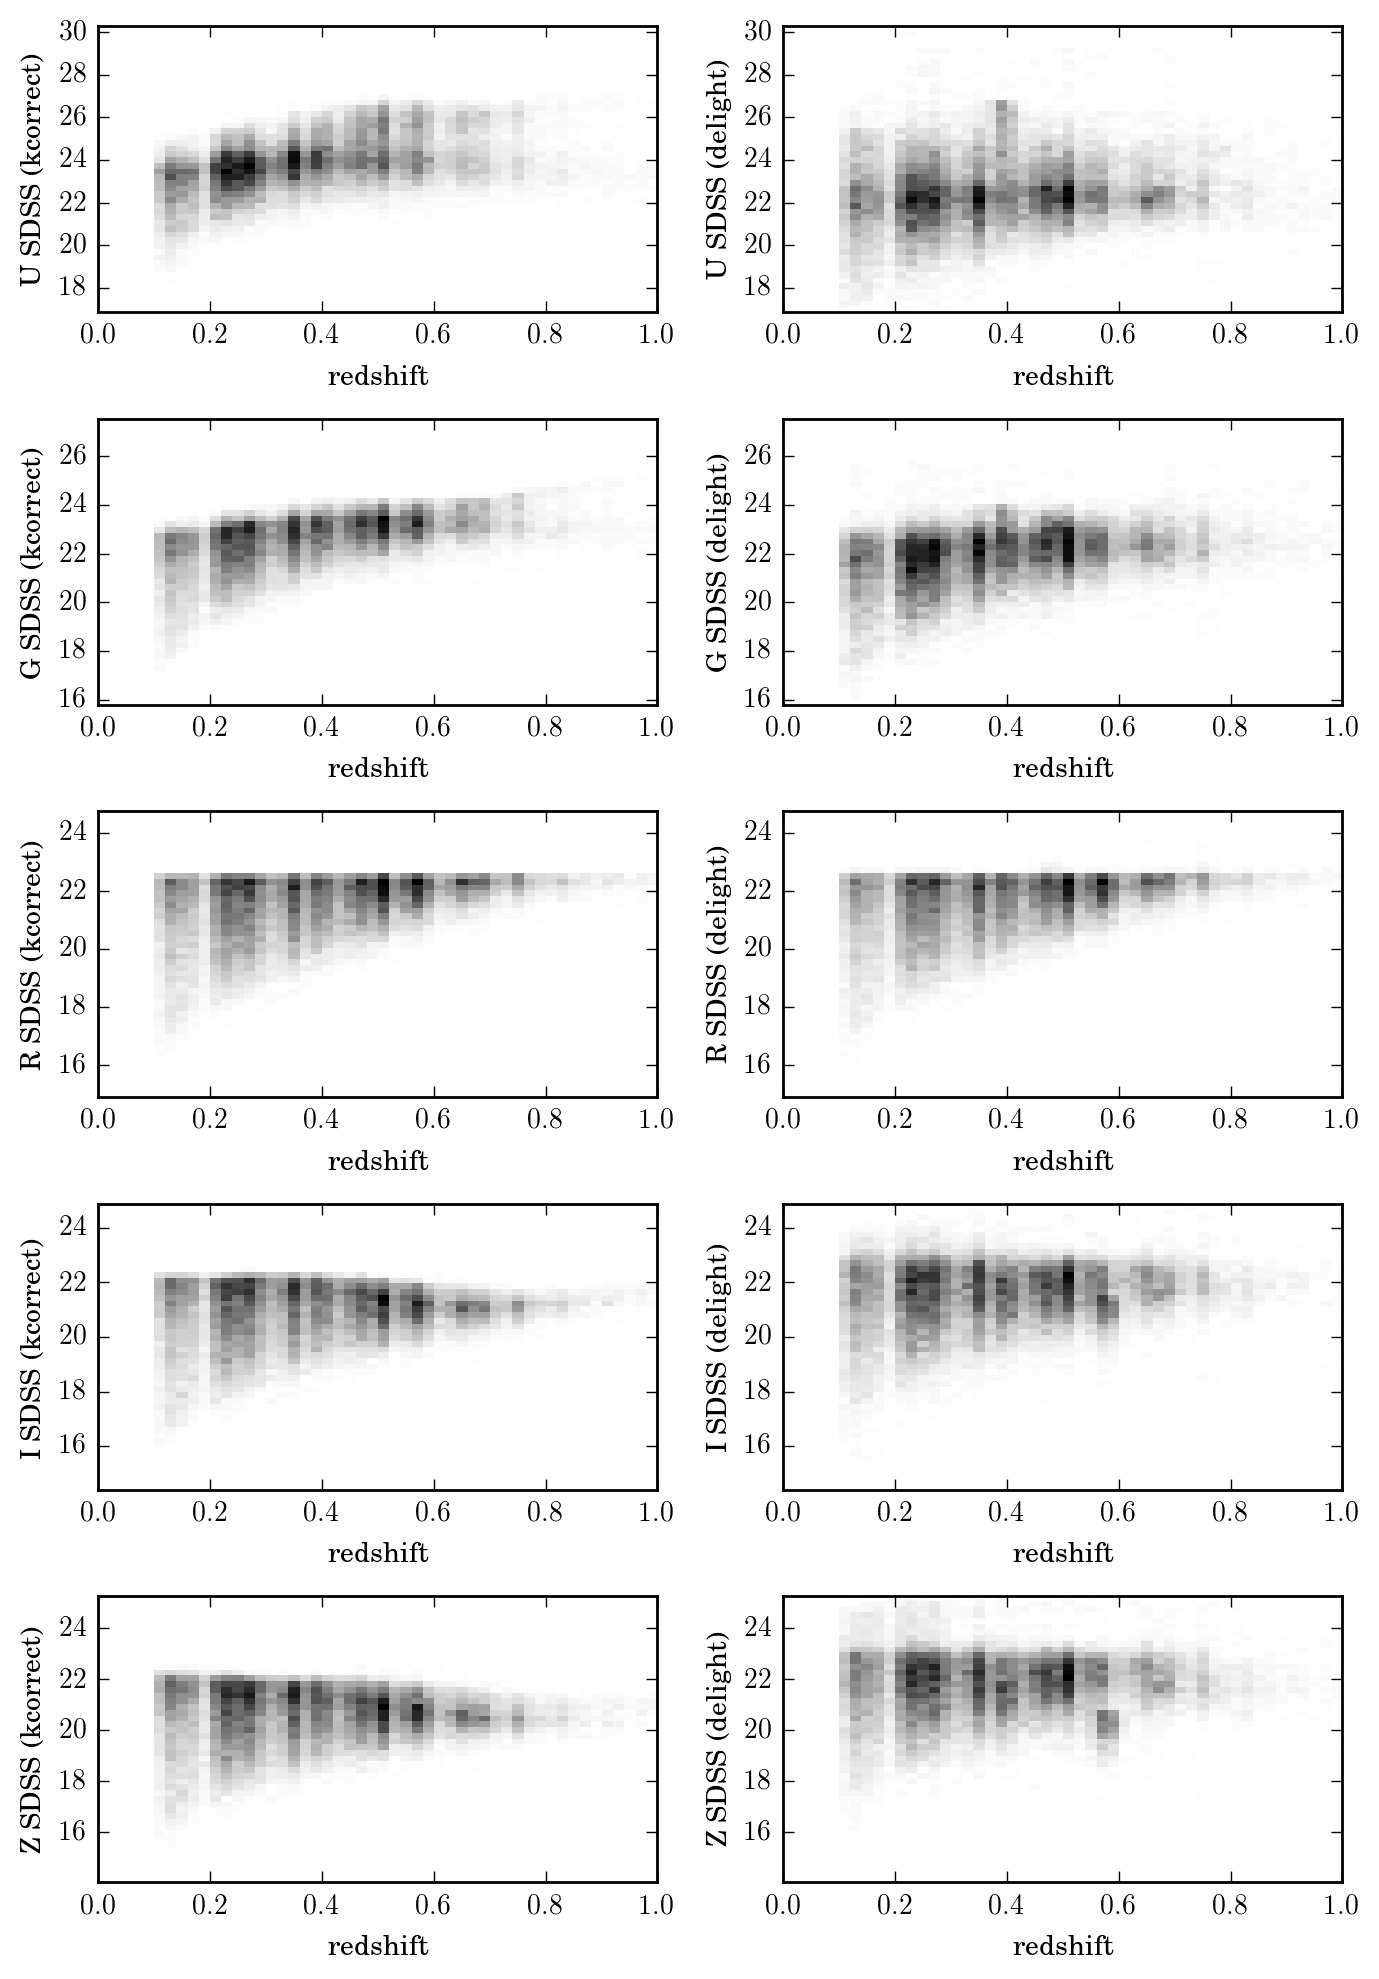

In [131]:
nbins = 50
fig, axs = plt.subplots(5, 2, figsize=(7, 10))
bands = ['U', 'G', 'R', 'I', 'Z']
for i in range(5):
    xmin, xmax = 0.95*np.min(all_sdss_mags[:, i]), 1.1*np.max(all_sdss_mags[:, i])
    axs[i, 0].hist2d(redshift[sel_sim], all_sdss_mags[:, i],
                  nbins, cmap='gray_r', range=[[0, 1], [xmin, xmax]])
    axs[i, 1].hist2d(redshift[sel_sim], all_new_sdss_mags[:, i],
                  nbins, cmap='gray_r', range=[[0, 1], [xmin, xmax]])
    #axs[i].set_xlim([0, 1])
    #axs[i].set_ylim([xmin, xmax])
    axs[i, 1].set_ylabel(bands[i]+' SDSS (delight)')
    axs[i, 0].set_ylabel(bands[i]+' SDSS (kcorrect)')
    axs[i, 1].set_xlabel('redshift')
    axs[i, 0].set_xlabel('redshift')
fig.tight_layout()